# Intro

Competition home page: https://www.kaggle.com/c/sartorius-cell-instance-segmentation

# Import Libraries

In [1]:
# Install pycocotools
!pip install pycocotools

     |████████████████████████████████| 106 kB 528 kB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370024 sha256=4212c18320529e991f72278b0c46256d46aefd594ddbb63c7c8ded4f92fedcab
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [2]:
# Install detecton2
# No pre-build for tocrch 1.9.1 and cuda 11.0. Consider cpu instead.
#!pip install detectron2 -f \
#  https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5jof72fy
  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5jof72fy
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2bd05b42983468c50a1c80d5e7dc3952980e1cd4
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 50 kB 434 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 74 kB 1.3 MB/s            
     |████████████████████████████████| 147 kB 2.9 MB/s            
     |████████████████████████████████| 130 kB 6.0 MB/s            
     |████████████████████████████████| 112 kB 6.0 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=6581147 sha256=e95a976bfb10ef84732d809bba8cc020d6687bc025498e38e765e1e4357fd00f
  Stored in directory: /

In [3]:
import os
import copy
import pickle
import argparse
import json
import random
import sys
import time
import datetime
import logging
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import pandas as pd
import numpy as np

from PIL import Image
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

import torch
from detectron2 import model_zoo
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator
from detectron2.config import CfgNode as CN
from detectron2.config import get_cfg
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.logger import setup_logger, log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine.hooks import HookBase
import detectron2.utils.comm as comm
from detectron2.data.datasets import register_coco_instances

from pycocotools import mask as maskUtils

# Set configs

In [4]:
cfgDict = {
    "dicomPath": None,
    "orgDataPath": "../input/sartorius-cell-instance-segmentation/",
    "trainJsonPath": "../input/crossvalidationfold5/coco_cell_train_fold3.json",
    "validJsonPath": "../input/crossvalidationfold5/coco_cell_valid_fold3.json",
    "newDataPath": None,
    "cachePath": "./",
    "trainDataName": "sartoriusTrain",
    "validDataName": "sartoriusValid",
    "sampleSize": 1000,
    "imSize": None,
    "modelName": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "mask_format": "bitmask",
    "debug": False,
    "outdir": "./results/",
    "logFile": "log.txt",
    "splitMode": True,
    "seed": 111,
    "device": "cuda",
    "iter": 1000,
    "ims_per_batch": 8,
    "roi_batch_size_per_image": 128,
    "eval_period": 50,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "checkpoint_period":500,
    "num_workers": 2,
    "score_thresh_test": 0.5,
    "augKwargs": {
        "RandomFlip": {"prob": 0.5},
        "RandomRotation": {"angle": [0,360]}
    }
}

setup_logger(os.path.join(cfgDict["outdir"],cfgDict["logFile"]))

<_Logger detectron2 (DEBUG)>

# Convert annotations to COCO format

We use the dataset https://www.kaggle.com/ammarnassanalhajali/crossvalidationfold5.

Example code is provided below.

In [5]:
# Decode rle to binary mask
def rle2mask(rle,h,w):
    # Reshape rle to (2, N) where 2 is for start and length
    rleArray = np.fromiter(rle.split(), dtype = np.uint)
    rleArray = rleArray.reshape((-1,2)).T
    rleArray[0] = rleArray[0] - 1
    # Decompress the rle length (eg, [3, 1, 10, 2] to [3, 4, 10, 11, 12]
    starts, lenghts = rleArray
    rleArray = np.concatenate([np.arange(s, s + l, dtype = np.uint) 
                                        for s, l in zip(starts, lenghts)])
    # Create the binary mask
    mask = np.zeros(h*w, dtype = np.uint8)
    mask[rleArray] = 1
    mask = mask.reshape((h,w))    
    # Convert to obj that pycocotools can handle
    mask = np.asfortranarray(mask) 
    
    return mask

In [6]:
# Encode the binary mask to COCO annotation with rle
def mask2annotation(idx, row, catIds):
    # rle to binary mask
    mask = rle2mask(row['annotation'],row['height'],row['width']) 
    # Encode to rle (coco format)
    rle = maskUtils.encode(mask) 
    # Convert from binary to utf-8
    rle['counts'] = rle['counts'].decode('utf-8')
    # Calculate the area
    area = maskUtils.area(rle).item()
    # Calculate the bboxes
    bbox = maskUtils.toBbox(rle).astype(int).tolist() 
    # Create COCO annotation
    annotation = {  'segmentation': rle,
                    'bbox': bbox,
                    'area': area,
                    'image_id':row['id'], 
                    'category_id':catIds[row['cell_type']], 
                    'iscrowd': 0, 
                    'id': idx }
    
    return annotation

In [7]:
# Create COCO format JSON
def df2COCO(cfg,df,workers=4):
    # Build header
    catIds = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in catIds.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 
               'file_name': f'train/{id}.png'} 
              for id,row in df.groupby('id').agg('first').iterrows()]
    
    # Build annotations
    annotations = Parallel(n_jobs=workers)(delayed(mask2annotation)(idx, row, catIds) 
                                           for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

In [8]:
# Save to json
df = pd.read_csv(os.path.join(cfgDict["orgDataPath"],"train.csv"))
df.head()
root = df2COCO(cfgDict,df[:cfgDict["sampleSize"]])
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Prepare augmentation

In [9]:
class AugMapper:
    """Custom mapper class for augmentations"""

    def __init__(self, cfg, isTrain=True):
        augKwargs = cfg["augKwargs"]
        augList = []
        # Define a sequence of augmentations
        if isTrain:
            augList.extend([getattr(T, name)(**kwargs) for name, kwargs in augKwargs.items()])
        self.augmentations = T.AugmentationList(augList)
        self.isTrain = isTrain
        self.cfg = cfg

    def __call__(self, datasetDict):
        datasetDict = copy.deepcopy(datasetDict)  # it will be modified by code below
        image = utils.read_image(datasetDict["file_name"], format="BGR")
        augInput = T.AugInput(image) # the augmentation input
        transforms = self.augmentations(augInput) # apply the augmentation
        image = augInput.image # new image
        imShape = image.shape[:2]  # h, w
        datasetDict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32")) # HWC to CHW
        annos = [ utils.transform_instance_annotations(annotation, transforms, imShape) 
                    for annotation in datasetDict.pop("annotations") 
                    if annotation.get("iscrowd", 0) == 0 ] # apply the augmentation to annotation
        instances = utils.annotations_to_instances(annos,imShape,mask_format=self.cfg.INPUT.MASK_FORMAT)
        datasetDict["instances"] = utils.filter_empty_instances(instances)
        
        return datasetDict

# Prepare loss eval hook for validation

In [10]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        comm.synchronize()

        return mean_loss
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)

# Custom DefaultTrainer

In [11]:
class MyTrainer(DefaultTrainer):
    """Overwrite DefaultTrainer methods"""
    
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AugMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, datasetName):
        return build_detection_test_loader(
            cfg, datasetName, mapper=AugMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, datasetName, outputFolder=None):
        if outputFolder is None:
            outputFolder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(datasetName, ("bbox",), False, output_dir=outputFolder)
    
    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks

# Load and register data

In [12]:
DatasetCatalog.clear()
register_coco_instances(cfgDict["trainDataName"],{},cfgDict["trainJsonPath"],cfgDict["orgDataPath"])
register_coco_instances(cfgDict["validDataName"],{},cfgDict["validJsonPath"],cfgDict["orgDataPath"])

metadata = MetadataCatalog.get(cfgDict["trainDataName"])
datasetTrain = DatasetCatalog.get(cfgDict["trainDataName"])
datasetValid = DatasetCatalog.get(cfgDict["validDataName"])

[04/17 17:36:32 d2.data.datasets.coco]: Loading ../input/crossvalidationfold5/coco_cell_train_fold3.json takes 2.05 seconds.
[04/17 17:36:32 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/crossvalidationfold5/coco_cell_train_fold3.json
[04/17 17:36:33 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/crossvalidationfold5/coco_cell_valid_fold3.json


# Visualize data

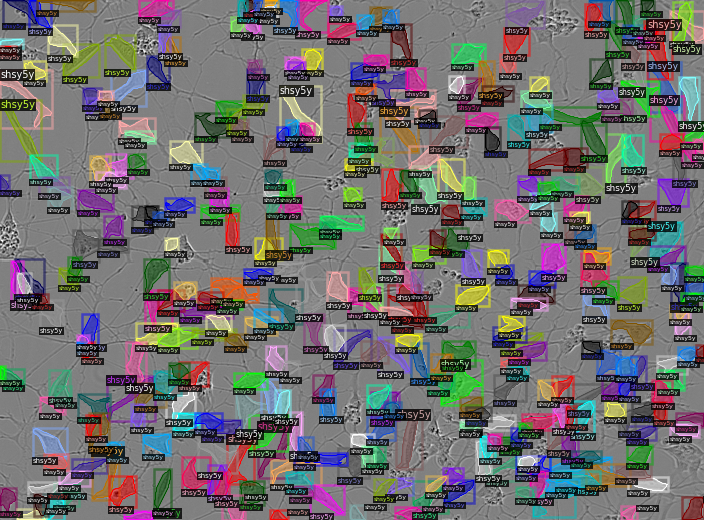

In [13]:
d = datasetTrain[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
out = visualizer.draw_dataset_dict(d)
Image.fromarray(out.get_image()[:, :, ::-1])

# Create Yacs config

In [14]:
cfg = get_cfg()

cfg.augKwargs = CN(cfgDict["augKwargs"])  # pass augKwargs to cfg as a CN
cfg.merge_from_file(model_zoo.get_config_file(cfgDict["modelName"]))
cfg.MODEL.DEVICE = cfgDict["device"]
cfg.OUTPUT_DIR = cfgDict["outdir"]
cfg.DATASETS.TRAIN = (cfgDict["trainDataName"],)
if cfgDict["splitMode"] is None:
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (cfgDict["validDataName"],)
    cfg.TEST.EVAL_PERIOD = cfgDict["eval_period"]
cfg.DATALOADER.NUM_WORKERS = cfgDict["num_workers"]
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfgDict["modelName"])
cfg.SOLVER.IMS_PER_BATCH = cfgDict["ims_per_batch"]
cfg.SOLVER.LR_SCHEDULER_NAME = cfgDict["lr_scheduler_name"]
cfg.SOLVER.BASE_LR = cfgDict["base_lr"]
cfg.SOLVER.MAX_ITER = cfgDict["iter"]
cfg.SOLVER.CHECKPOINT_PERIOD = cfgDict["checkpoint_period"]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = cfgDict["roi_batch_size_per_image"]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata.get("thing_classes"))
cfg.INPUT.MASK_FORMAT = cfgDict["mask_format"]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = cfgDict["score_thresh_test"]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train model

In [15]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/17 17:36:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:08, 20.0MB/s]                           


[04/17 17:36:58 d2.engine.train_loop]: Starting training from iteration 0
[04/17 17:38:42 d2.utils.events]:  eta: 1:23:15  iter: 19  total_loss: 7.127  loss_cls: 1.502  loss_box_reg: 0.3421  loss_mask: 0.6911  loss_rpn_cls: 4.162  loss_rpn_loc: 0.3904  time: 4.6950  data_time: 3.5543  lr: 9.81e-07  max_mem: 8940M
[04/17 17:40:24 d2.utils.events]:  eta: 1:11:34  iter: 39  total_loss: 6.451  loss_cls: 1.492  loss_box_reg: 0.3222  loss_mask: 0.691  loss_rpn_cls: 3.531  loss_rpn_loc: 0.3882  time: 4.8984  data_time: 3.7481  lr: 9.61e-07  max_mem: 9961M
[04/17 17:41:07 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/crossvalidationfold5/coco_cell_valid_fold3.json
[04/17 17:41:07 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[04/17 17:41:07 d2.data.common]: Serialized dataset takes 1.75 MiB
[04/17 17:41:08 d2.evaluation.evaluator]: Start inference on 121 batches
[04/17 17:41:11 d2.evaluation.evaluator]: Inference done 11/121. 

# Evaluation

In [16]:
import pandas as pd
dfMetrics = pd.read_json(os.path.join(cfgDict["outdir"],"metrics.json"), orient="records", lines=True)
dfMetrics = dfMetrics.sort_values("iteration")
dfMetrics.head()

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,...,rpn/num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,4.088982,4995.822665,0.136719,0.118398,0.248047,19,0.342134,1.502229,0.691062,4.161671,...,126.3750,5.097778,7.126757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.104116,4294.983660,0.139160,0.124162,0.222804,39,0.322212,1.491887,0.691002,3.531189,...,124.6875,4.357445,6.451071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,49,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.049649
2,2.330727,4043.032064,0.102051,0.195312,0.112301,59,0.314658,1.487517,0.690598,2.898039,...,128.0000,3.551350,5.763102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.275829,3957.010105,0.128418,0.195695,0.164659,79,0.318504,1.475290,0.690293,2.146566,...,125.0000,4.492791,5.016504,NaN,NaN,NaN,NaN,NaN,NaN,NaN


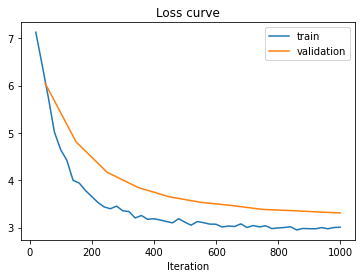

In [17]:
dfTrainLoss = dfMetrics[~dfMetrics["total_loss"].isna()]
plt.plot(dfTrainLoss["iteration"], dfTrainLoss["total_loss"], c="C0", label="train")
if "validation_loss" in dfMetrics.columns:
    dfValidLoss = dfMetrics[~dfMetrics["validation_loss"].isna()]
    plt.plot(dfValidLoss["iteration"], dfValidLoss["validation_loss"], c="C1", label="validation")

plt.legend()
plt.title("Loss curve")
plt.xlabel("Iteration")
plt.show()

# Predict

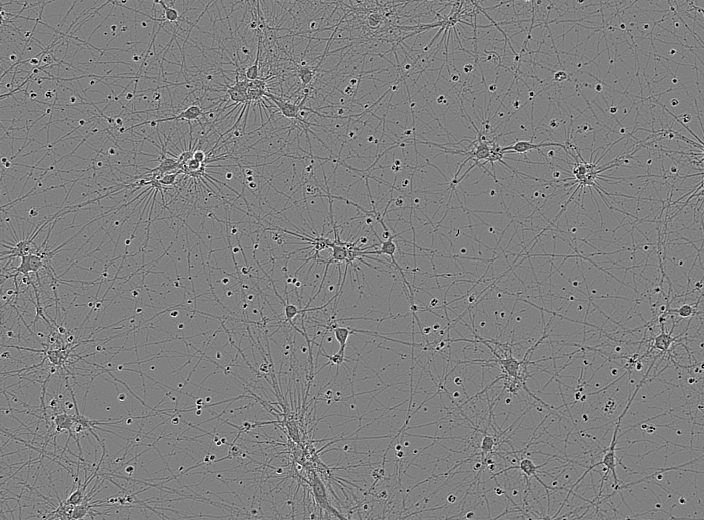

In [18]:
# Same cfg from trainer and use the final model output to initialize the predictor
cfg.MODEL.WEIGHTS = os.path.join(cfgDict["outdir"],"model_final.pth")
predictor = DefaultPredictor(cfg)

d = datasetTrain[3]
im = cv2.imread(d["file_name"])
if predictor.input_format == "RGB":
    im = im[:, :, ::-1]
height, width = im.shape[:2]
image = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))
inputs = [{"image": image, "height": height, "width": width}]
outputs = predictor.model(inputs)
output = outputs[0]

visualizer = Visualizer(im,metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
out = visualizer.draw_instance_predictions(output["instances"].to("cpu"))
Image.fromarray(out.get_image()[:, :, ::-1])

# References

https://www.kaggle.com/coldfir3/efficient-coco-dataset-generator

https://cocodataset.org/#format-data

https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py